# Views on risk factors
This example illustrates how to implement Entropy Pooling views on risk factors as, e.g., implied vol and government bond zero-coupon curves. For convenience, the risk factors and P&Ls are combined into one matrix R as described in https://ssrn.com/abstract=3936392.

You can watch a video walkthrough of the example here: https://youtu.be/pvWKIRwPGHc.

In [1]:
import numpy as np
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Load raw time series data and compute stationary transformations
Before generating the prior P&L simulation, we load the raw time series data and compute stationary transformations that are easier to project into the future.

In [2]:
# Load the simulated time series data
time_series = ft.load_time_series()

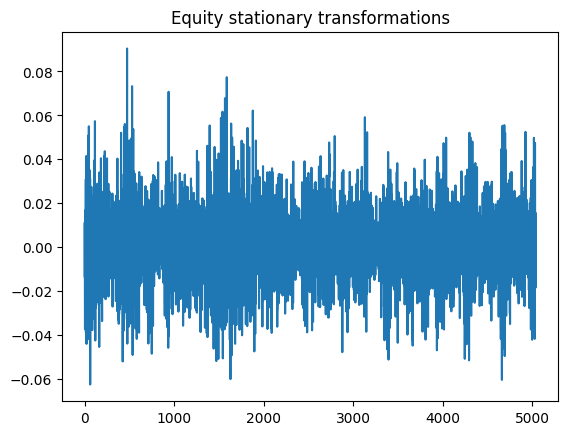

In [3]:
# Compute equity stationary transformations
eqt_log_chg = np.diff(np.log(time_series.iloc[:, 0]))
plt.plot(eqt_log_chg)
plt.title('Equity stationary transformations')
plt.show()

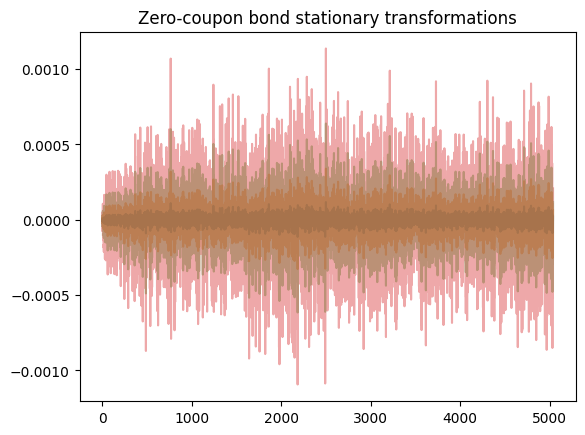

In [4]:
# Compute government bond stationary transformations
zcb_maturities = np.hstack((np.array([1/12, 1/4, 1/2]), np.arange(1, 31)))
zcb_df = np.exp(-time_series.iloc[:, 1:34] / 100 * zcb_maturities)
zcb_log_chg = np.diff(np.log(zcb_df), axis=0)
plt.plot(zcb_log_chg[:, [0, 1, 2, 3]], alpha=0.4)
plt.title('Zero-coupon bond stationary transformations')
plt.show()

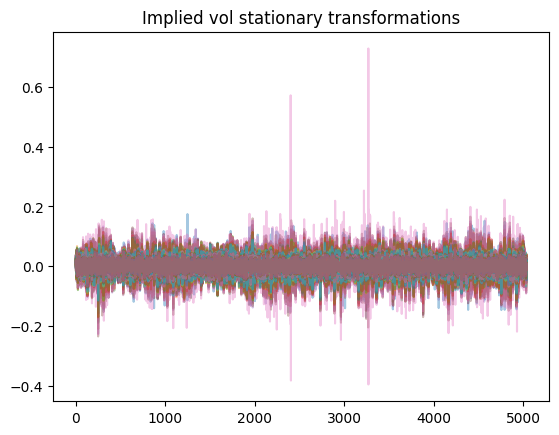

In [5]:
# Compute implied vol stationary transformations
vol_log_chg = np.diff(np.log(time_series.iloc[:, 34:69]), axis=0)
plt.plot(vol_log_chg, alpha=0.4)
plt.title('Implied vol stationary transformations')
plt.show()

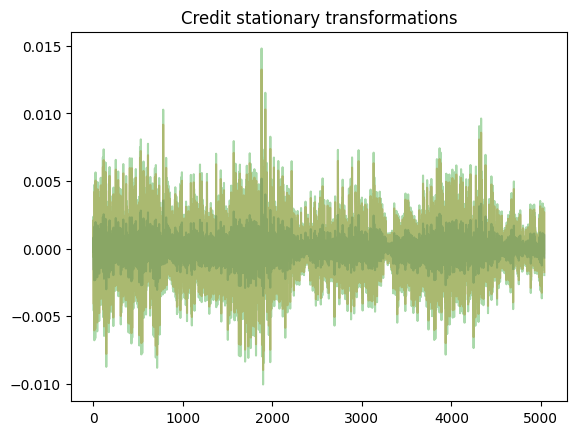

In [6]:
# Compute credit stationary transformations
cr_maturities = np.arange(1, 11)
cr_df = np.exp(-time_series.iloc[:, 69:] / 100 * cr_maturities)
cr_log_chg = np.diff(np.log(cr_df), axis=0)
plt.plot(cr_log_chg[:, [0, 4, 9]], alpha=0.4)
plt.title('Credit stationary transformations')
plt.show()

# Computing the one-step-ahead risk factor distribution
With the stationary transformations at hand, we compute the one-step-ahead distributions for all risk factors by simply using the historical realizations. For real-world applications, a more sophisticated simulation engine should be used which also allows us to project further into the future instead of just one-step-ahead. This is however beyond the scope of this example.

The interested reader can also explore exponentially decaying prior probabilities available through the ft.exp_decay_probs function, but this is still a very simple way of modeling the one-step-ahead risk factor distribution.

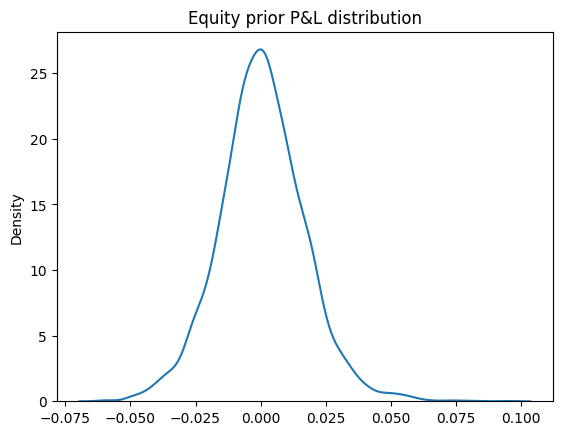

In [7]:
# Prior equity return
eqt_pnl = np.exp(eqt_log_chg) - 1
sns.kdeplot(eqt_pnl)
plt.title('Equity prior P&L distribution')
plt.show()

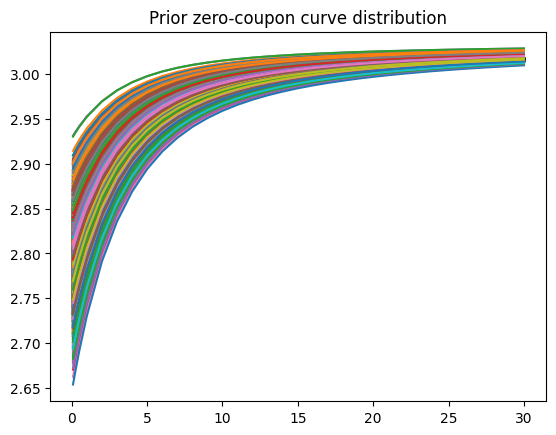

In [8]:
# Prior zero-coupon curve distribution
df_sim = np.exp(zcb_log_chg) * zcb_df.values[-1, :]
zcb_curve_sim = -np.log(df_sim) / zcb_maturities
plt.plot(zcb_maturities, 100 * zcb_curve_sim.T)
plt.title('Prior zero-coupon curve distribution')
plt.show()

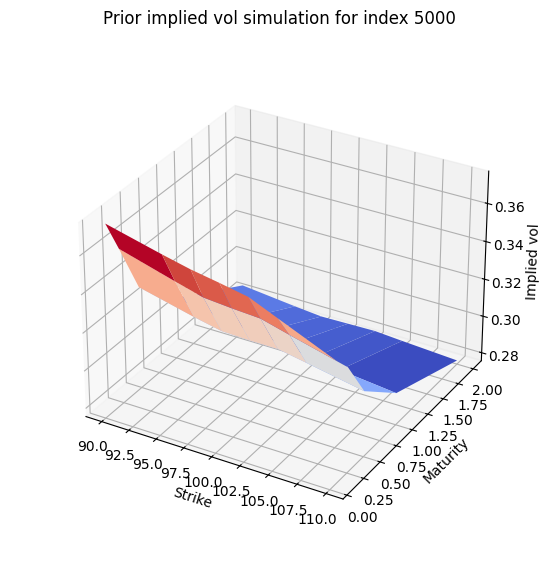

In [9]:
# Implied vol surface distribution
imp_vol_sim = np.exp(vol_log_chg) * time_series.values[-1, 34:69] / 100
index = 5000
fig, ax = ft.plot_vol_surface(index, imp_vol_sim)
plt.title(f'Prior implied vol simulation for index {index}')
plt.show()

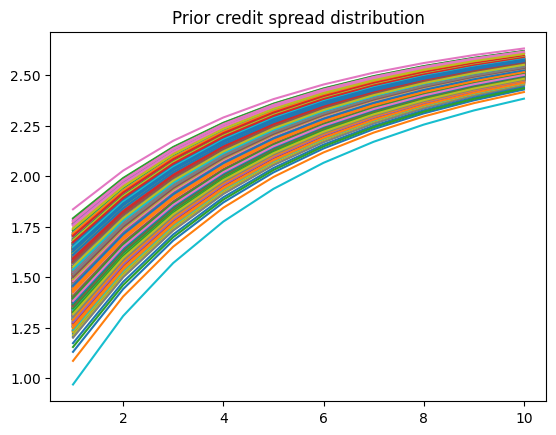

In [10]:
# Prior credit spread distribution
cr_sim = np.exp(cr_log_chg) * cr_df.values[-1, :]
cr_curve_sim = -np.log(cr_sim) / cr_maturities
plt.plot(cr_maturities, 100 * cr_curve_sim.T)
plt.title('Prior credit spread distribution')
plt.show()

# Pricing
With the risk factor distribution at hand, we can continue with pricing of the relevant instruments. We assume that we have a portfolio of an equity index, a government bond, a credit bond and an ATMF put option written on the equity index.

We make some simplifying assumptions when pricing the instruments, e.g., we ignore the 1 day time difference when computing the bond and option prices to avoid making interpolation assumptions. This assumption should have very little practical effect on the P&L.

See https://ssrn.com/abstract=4217884 for the definition of relative P&L. For equity and bonds, relative P&L is simply the conventional return.

In [11]:
# Create cash flows for the bonds
gov_cf = 3 * np.ones(10)
gov_cf[-1] = gov_cf[-1] + 100
cr_cf = 3 + gov_cf

In [12]:
# Compute relative P&L
gov_price = zcb_df.values[-1, 0:10] @ gov_cf
gov_relative_pnl = (df_sim[:, 0:10] @ gov_cf - gov_price) / gov_price
cr_price = (zcb_df.values[-1, 0:10] * cr_df.values[-1, :]) @ cr_cf
cr_relative_pnl = ((df_sim[:, 0:10] * cr_sim[:, :]) @ cr_cf - cr_price) / cr_price

In [13]:
# Compute current put options price
fwd_3m = 1 / zcb_df.values[-1, 1]
imp_vol_3m = time_series['3m100'].values[-1] / 100
zcp_rate_3m = time_series['3m'].values[-1] / 100
atmf_put_3m = ft.put_option(fwd_3m, fwd_3m, imp_vol_3m, zcp_rate_3m, 1/4)

In [14]:
# Find index of 3m interst rate
rate_index = int(np.where(time_series.columns[1:34] == '3m')[0][0])

# Extract simulated rates
zcp_rate_sim = zcb_curve_sim[:, rate_index]

# Compute relevant simulated forward
fwd_sim = (1 + eqt_pnl) / df_sim[:, rate_index]

# Find index of 3m ATMF vol index
vol_index = int(np.where(time_series.columns[34:69] == '3m100')[0][0])

# Extract simulated implied vols
vol_sim = imp_vol_sim[:, vol_index]

In [15]:
# Compute put relative P&L
S = len(vol_sim)
put_relative_pnl = np.full(S, np.nan)
for i in range(S):
    put_relative_pnl[i] = ft.put_option(fwd_sim[i], fwd_3m, vol_sim[i], zcp_rate_sim[i], 1/4) - atmf_put_3m

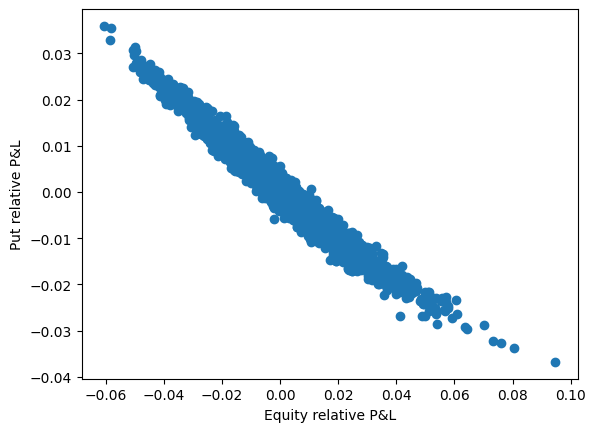

In [16]:
# Put option sanity check
plt.scatter(eqt_pnl, put_relative_pnl)
plt.ylabel('Put relative P&L')
plt.xlabel('Equity relative P&L')
plt.show()

# Combine risk factor simulation and P&L into one matrix
As described in https://ssrn.com/abstract=3936392, it is convenient to combine all the risk factors and prices / P&L into one matrix R when implementing views / stress-testing with Entropy Pooling.

In [17]:
risk_factors_sim = np.hstack((zcb_curve_sim, imp_vol_sim, cr_curve_sim))
pnl_sim = np.vstack((eqt_pnl, gov_relative_pnl, cr_relative_pnl, put_relative_pnl)).T
R = np.hstack((risk_factors_sim, pnl_sim))

# Entropy Pooling views on risk factors
Below we implement a view that the 1m zero-coupon rate increases by two standard deviations, while the 1m implied vol increases by one standard deviation. Finally, we visualize the effect for the portfolio P&L with kernel density plots.

In [18]:
# Implement a view with a one standard deviation increase in the short rate and 1m ATMF implied vol
A = np.ones((1, S))  # Probabilities sum to one
rate_1m = R[:, 0][np.newaxis]  # 1m zero-coupon rate
A = np.vstack((A, rate_1m))
vol_index2 = int(np.where(time_series.columns == '1m100')[0][0] - 1)
vol_1m = R[:, vol_index2]
A = np.vstack((A, vol_1m))
b = np.array([[1], [np.mean(rate_1m) + 2 * np.std(rate_1m)],
              [np.mean(vol_1m) + 1 * np.std(vol_1m)]])

In [19]:
# Entropy Pooling posterior prob
q = ft.entropy_pooling(np.ones((S, 1)) / S, A, b)

# Compute posterior and verify that views are satisfied
mean_post = q.T @ R
print(mean_post[0, 0] - b[1, 0])
print(mean_post[0, vol_index2] - b[2, 0])

6.420392762579441e-09
-1.2386430059407871e-07


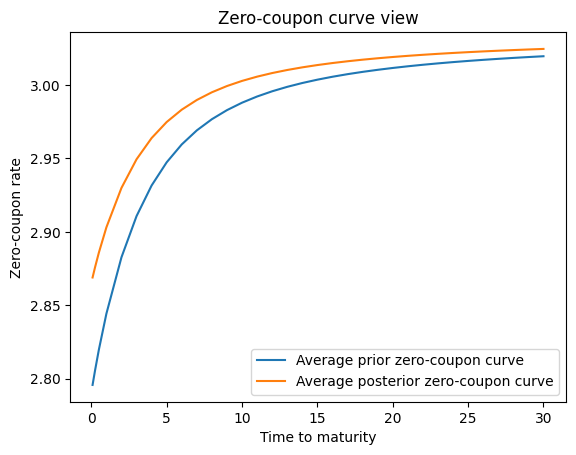

In [20]:
# Plot average posterior zero-coupon curve
plt.plot(zcb_maturities, 100 * np.mean(zcb_curve_sim, axis=0))
plt.plot(zcb_maturities, 100 * mean_post[0, 0:33])
plt.ylabel('Zero-coupon rate')
plt.xlabel('Time to maturity')
plt.title('Zero-coupon curve view')
plt.legend(['Average prior zero-coupon curve', 'Average posterior zero-coupon curve'])
plt.show()

# Portfolio P&L
Next we specify some portfolio and plot a kernel density estimate for its P&L for both the prior and posterior distributions.

We use the framework from https://ssrn.com/abstract=4217884, i.e., the portfolio weights sum to one, but the portfolio exposures do not need to sum to one.

In [21]:
# Define a vector of relative exposures
exposure_equity = 0.30
exposure_put = 0.30
weight_put = 0.30 * atmf_put_3m
exposure_gov = 0.5
exposure_credit = 1 - exposure_equity - weight_put - exposure_gov
e = [exposure_equity, exposure_gov, exposure_credit, exposure_put]

# Verify that weights sum to 1
print(f'Portfolio weight sum is: {np.sum(np.sum(e[0:3]) + weight_put)}')

# Compute portfolio P&L
pnl_pf = R[:, -4:] @ e

Portfolio weight sum is: 1.0


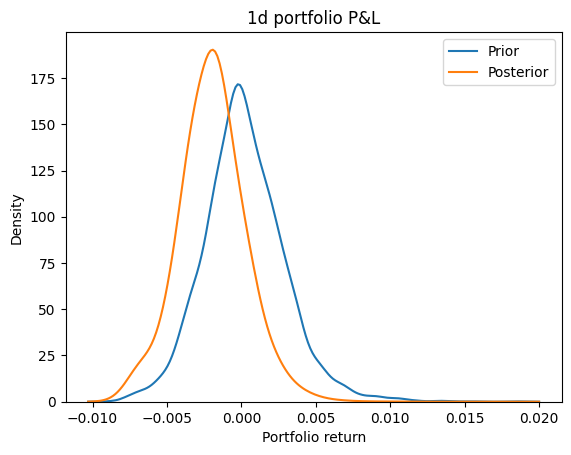

In [22]:
# Compare prior and posterior portfolio P&L
sns.kdeplot(x=pnl_pf)
sns.kdeplot(x=pnl_pf, weights=q[:, 0])
plt.title('1d portfolio P&L')
plt.legend(['Prior', 'Posterior'])
plt.xlabel('Portfolio return')
plt.show()

# Conclusion
This example illustrates how to implement views on risk factors and assess the effect on portfolio P&L. P&L and risk factors are combined into one matrix R as described in https://ssrn.com/abstract=3936392. See the other Entropy Pooling examples for views on assets returns directly.

# License

In [23]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2025 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.